In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
import shap

In [3]:
# print the JS visualization code to the notebook
shap.initjs()

In [4]:
# visualization tool
from matplotlib import pyplot as plt
import seaborn as sns 

In [5]:
df = pd.read_csv('SD4A.csv')
df.head()

,Yr,ID,PDB1,PDB2,PDB3,PDB4,PGJ_A1,PGJ_B1,PGJ_A2,PGJ_B2,...,KDR_D2,KDR_D3,KDR_D4,KDR_D5,KDR_U1,KDR_U2,KDR_U3,KDR_U4,KDR_U5,KDR_M
0,2014,3201,7.077431e+09,5.721087e+10,2.794664e+10,4.852551e+08,4421329,26264,4075198,54927,...,121,946,3455,484,0,323,9561,0,3573,779462
1,2014,3202,1.558792e+08,8.017671e+08,2.601502e+09,1.108916e+09,111947,2849,2031979,49985,...,31,562,3308,205,0,269,3640,0,365,274545
2,2014,3203,7.105471e+08,4.337768e+09,2.490762e+09,1.665761e+09,665422,36518,292919,7824,...,30,449,3882,112,0,368,3959,0,807,241114
3,2014,3204,7.063139e+08,2.311227e+09,6.894598e+09,6.690000e+08,2061000,11,5583468,62101,...,63,685,2408,214,0,539,5469,0,2611,616652
4,2014,3205,1.500000e+06,1.446990e+09,0.000000e+00,3.319860e+08,43000,685,2248419,6344,...,13,532,2611,127,0,757,1749,0,1453,225443


In [6]:
len(df)

188

In [7]:
# Decide value
df_PDB2 = df.drop(columns=['PDB1','PDB3','PDB4'])

In [8]:
# Remove Zero Depdendant variables
df_PDB2a = df_PDB2[df_PDB2['PDB2'] != 0]
len(df_PDB2a)

188

<AxesSubplot:>

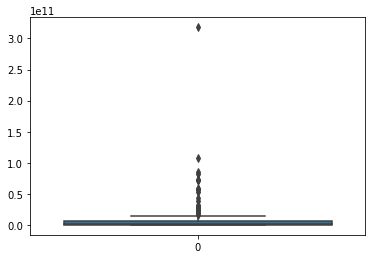

In [9]:
### Check Outlier Data 
f, axes = plt.subplots(1, 1)

sns.boxplot(data=df_PDB2a.PDB2)

In [10]:
# Remove Outlier Value PDB2 > 3.0 le11

df_PDB2b = df_PDB2a[df_PDB2a['PDB2'] < 100.000.000.000]

<AxesSubplot:>

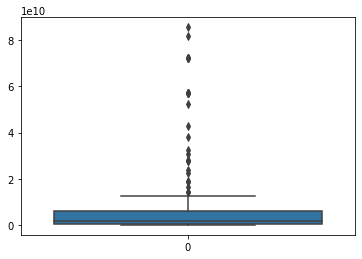

In [11]:
### Check Outlier Data 
f, axes = plt.subplots(1, 1)

sns.boxplot(data=df_PDB2b.PDB2)

In [12]:
len(df_PDB2b)

186

In [13]:
#### df_PDB2 : Total Pendapatan Daerah sektor Perhotelan #####

In [14]:
df_PDB2b.columns

Index(['Yr', 'ID', 'PDB2', 'PGJ_A1', 'PGJ_B1', 'PGJ_A2', 'PGJ_B2', 'PGJ_A3',
       'PGJ_B3', 'NIGHT_AR', 'NIGHT_CF', 'CH', 'JML_HJ', 'LA', 'JML1', 'JML2',
       'JML2A', 'JML3', 'JML3A', 'JML4', 'KSN1', 'KSN2', 'KSN3', 'KSN4',
       'KSN5', 'KSN6', 'KSN7', 'KSN8', 'HBR1', 'HBR2', 'HBR3', 'HBR4', 'HBR5',
       'HBR6', 'HBR7', 'UMK1', 'PDP1', 'PDP2', 'PDP3', 'PDP4', 'PDP5', 'PDP6',
       'PDPT1', 'PDPT2', 'PDPT3', 'PDPT4', 'LK', 'PR', 'LK4', 'LK5', 'LK6',
       'LK7', 'LK8', 'PR4', 'PR5', 'PR6', 'PR7', 'PR8', 'JML_HT', 'JML_HT1',
       'JML_JK1', 'JML_JK2', 'JML_JK3', 'JML_JK4', 'JML_JK5', 'JML_JK6',
       'JML_HTA', 'JML_HTA1', 'JML_HTA2', 'KDR_P1', 'KDR_P2', 'KDR_P3',
       'KDR_P4', 'KDR_P5', 'KDR_D1', 'KDR_D2', 'KDR_D3', 'KDR_D4', 'KDR_D5',
       'KDR_U1', 'KDR_U2', 'KDR_U3', 'KDR_U4', 'KDR_U5', 'KDR_M'],
      dtype='object')

In [15]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [16]:
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning import grid_search_params as gsp

In [17]:
X = df_PDB2b.drop(columns='PDB2')
y = df_PDB2b.PDB2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((148, 84), (38, 84), (148,), (38,))

In [18]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), 
     ['Yr', 'ID', 'PGJ_A1', 'PGJ_B1', 'PGJ_A2', 'PGJ_B2', 'PGJ_A3',
       'PGJ_B3', 'NIGHT_AR', 'NIGHT_CF', 'CH', 'JML_HJ', 'LA', 'JML1', 'JML2',
       'JML2A', 'JML3', 'JML3A', 'JML4', 'KSN1', 'KSN2', 'KSN3', 'KSN4',
       'KSN5', 'KSN6', 'KSN7', 'KSN8', 'HBR1', 'HBR2', 'HBR3', 'HBR4', 'HBR5',
       'HBR6', 'HBR7', 'UMK1', 'PDP1', 'PDP2', 'PDP3', 'PDP4', 'PDP5', 'PDP6',
       'PDPT1', 'PDPT2', 'PDPT3', 'PDPT4', 'LK', 'PR', 'LK4', 'LK5', 'LK6',
       'LK7', 'LK8', 'PR4', 'PR5', 'PR6', 'PR7', 'PR8', 'JML_HT', 'JML_HT1',
       'JML_JK1', 'JML_JK2', 'JML_JK3', 'JML_JK4', 'JML_JK5', 'JML_JK6',
       'JML_HTA', 'JML_HTA1', 'JML_HTA2', 'KDR_P1', 'KDR_P2', 'KDR_P3',
       'KDR_P4', 'KDR_P5', 'KDR_D1', 'KDR_D2', 'KDR_D3', 'KDR_D4', 'KDR_D5',
       'KDR_U1', 'KDR_U2', 'KDR_U3', 'KDR_U4', 'KDR_U5', 'KDR_M'])
])

In [19]:
# PENGOLAHAN TAHAP - I

## XGBOOST ##

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

In [20]:
model = RandomizedSearchCV(pipeline,  rsp.xgb_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

melihat sebatas Variance dan Trend
Root means squared error


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.0min finished


{'algo__colsample_bytree': 0.6582785962181182, 'algo__gamma': 2, 'algo__learning_rate': 0.4074640851692728, 'algo__max_depth': 7, 'algo__n_estimators': 137, 'algo__reg_alpha': 0.294479351736802, 'algo__reg_lambda': 8.353161927650396, 'algo__subsample': 0.6040439247709426}
0.9999924863749494 0.8089853390189287 0.8313180302286451


In [28]:
from sklearn.metrics import mean_squared_error

In [31]:
len(X_train)

148

In [32]:
len(y_train)

148

In [30]:
print(mean_squared_error(X_train, y_train))

ValueError: y_true and y_pred have different number of output (84!=1)

In [23]:
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

0.9999924863749494 0.8089853390189287 0.8313180302286451


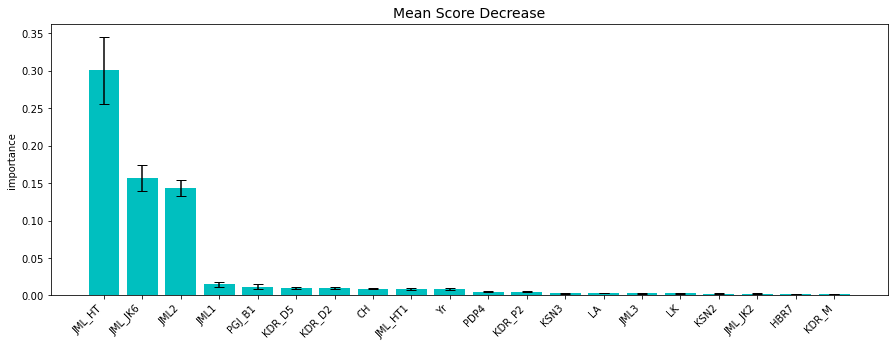

In [21]:
df_im = mean_score_decrease(X_train, y_train, model, plot=True, topk=20)

In [25]:
xgb_msc = mean_score_decrease(X_train, y_train, model, topk=20)
xgb_msc

,feature,importance,stdev
57,JML_HT,0.300512,0.044929
64,JML_JK6,0.156493,0.017509
14,JML2,0.143507,0.010563
13,JML1,0.014808,0.003485
3,PGJ_B1,0.011967,0.002855
77,KDR_D5,0.010465,0.001228
74,KDR_D2,0.009609,0.001312
10,CH,0.009282,0.001217
58,JML_HT1,0.008778,0.001227
0,Yr,0.008767,0.001538


In [22]:
# PENGOLAHAN TAHAP - II
# Pengolahan menggunaakn 20 fitur dengan nilai Feature Importance terbaik
# Dilakukan proses secara berulang (trial & error) hingga mendapatkan fitur-fitur yang menghasilkan pemodelan terbaik

X = df_PDB2b.drop(columns='PDB2')
y = df_PDB2b.PDB2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((148, 84), (38, 84), (148,), (38,))

In [23]:
## Berikut adalah fitur-fitur akhir proses perulangan dan menghasilkan pemodelan terbaik

preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2), 
     ['JML_HT','PGJ_A1', 'PGJ_B1', 'PGJ_A2', 'PGJ_B2',
'ID','Yr',
'JML2',
'KDR_D5',
'NIGHT_AR',
'JML1',
'JML_HTA2',
'JML3A',
'JML3',
'KDR_D3',
'KDR_U3',
'KDR_P5',
'KDR_P4',
'KDR_P2',
'HBR7',
'UMK1',
'LK',
'JML2A',
'KDR_P1'
])
])

In [24]:
## XGBOOST ##
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

In [25]:
model = RandomizedSearchCV(pipeline,  rsp.xgb_params, cv=3, n_iter=100, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   27.8s finished


{'algo__colsample_bytree': 0.9555464322438006, 'algo__gamma': 3, 'algo__learning_rate': 0.09683922731886012, 'algo__max_depth': 5, 'algo__n_estimators': 168, 'algo__reg_alpha': 0.014888230597983571, 'algo__reg_lambda': 0.020637552043950225, 'algo__subsample': 0.6362592280385193}
0.9999988267815346 0.8545728550154905 0.8450768445274324


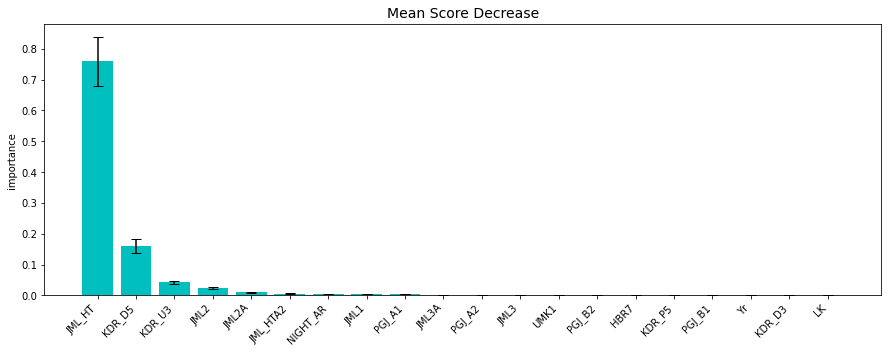

In [26]:
df_im = mean_score_decrease(X_train, y_train, model, plot=True, topk=20)

In [27]:
xgb_msc = mean_score_decrease(X_train, y_train, model, topk=20)
xgb_msc

,feature,importance,stdev
57,JML_HT,0.759452,0.079918
77,KDR_D5,0.159164,0.022742
80,KDR_U3,0.042325,0.005046
14,JML2,0.024047,0.003495
15,JML2A,0.009882,0.002136
67,JML_HTA2,0.006032,0.001184
8,NIGHT_AR,0.004425,0.000289
13,JML1,0.004305,0.000438
2,PGJ_A1,0.004131,0.000388
17,JML3A,0.002442,0.000153


In [32]:
## Run Back Line 141-142
## Random Forest ##

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestRegressor(n_jobs=-1, random_state=42))
])

In [33]:
model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3,n_iter=100, n_jobs=-1, verbose=1, random_state=42)
a =  model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   22.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.7s finished


{'algo__max_depth': 44, 'algo__max_features': 0.6503623397791125, 'algo__min_samples_leaf': 7, 'algo__n_estimators': 156}
0.9357827699103002 0.8051028839136277 0.9224122968589925


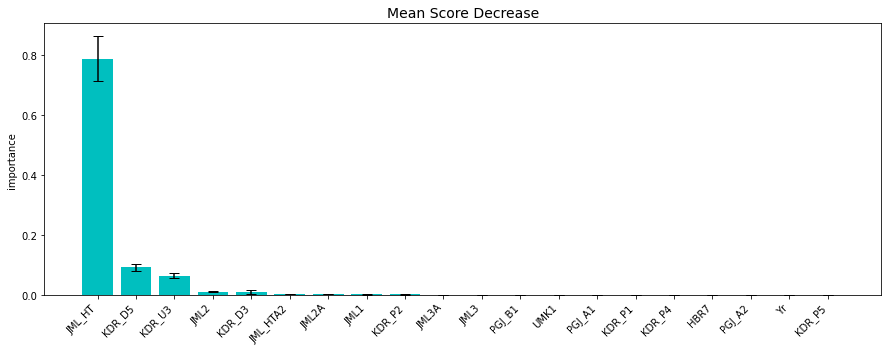

In [151]:
df_im = mean_score_decrease(X_train, y_train, model, plot=True, topk=20)

In [152]:
rf_msc = mean_score_decrease(X_train, y_train, model, topk=20)
rf_msc

,feature,importance,stdev
57,JML_HT,0.787172,0.074093
77,KDR_D5,0.092065,0.012454
80,KDR_U3,0.064021,0.008156
14,JML2,0.012056,0.001733
75,KDR_D3,0.011524,0.007234
67,JML_HTA2,0.003162,0.000576
15,JML2A,0.002898,0.000456
13,JML1,0.002626,0.000563
69,KDR_P2,0.002154,0.001036
17,JML3A,0.001643,0.000210


In [ ]:
# Setelah Mendapatkan komponen fitur terbaik dari pengolahan sebelumnya dengan menggunakan XGBOOST dan Random Forest
# Dilanjutkan dengan perhitungan parameter nilai SHAP

In [16]:
import xgboost

In [17]:
X1 = df_PDB2b[['JML_HT','PGJ_A1', 'PGJ_B1', 'PGJ_A2', 'PGJ_B2',
'ID','Yr',
'JML2',
'KDR_D5',
'NIGHT_AR',
'JML1',
'JML_HTA2',
'JML3A',
'JML3',
'KDR_D3',
'KDR_U3',
'KDR_P5',
'KDR_P4',
'KDR_P2',
'HBR7',
'UMK1',
'LK',
'JML2A',
'KDR_P1']]

In [18]:
X = X1
y = df_PDB2b.PDB2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((148, 24), (38, 24), (148,), (38,))

In [19]:
model1 = xgboost.XGBRegressor(n_jobs=1, verbosity=1, random_state=42, cv=3,n_iter=100).fit(X_train, y_train)

[21:14:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cv", "n_iter" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [20]:
print(model1.score(X_train, y_train))
print(model1.score(X_test, y_test))

0.9999999999874485
0.8902853434476445


In [21]:
model1

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, cv=3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_iter=100, n_jobs=1, num_parallel_tree=1,
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=1)

In [22]:
explainer = shap.Explainer(model1)

In [23]:
explainer

In [24]:
shap_values = explainer(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [25]:
len(shap_values[0])

24

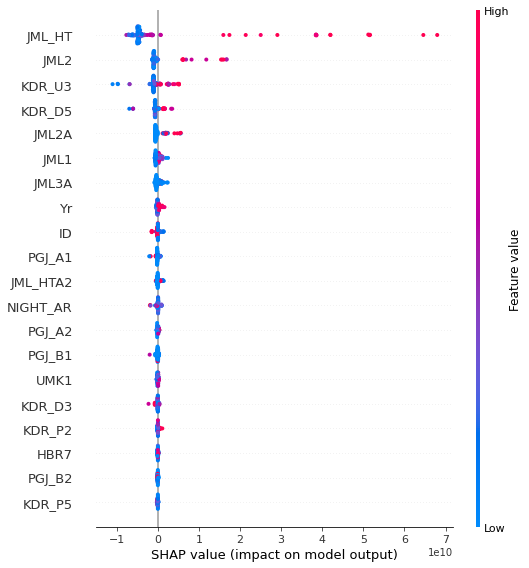

In [26]:
shap.summary_plot(shap_values, X_train)

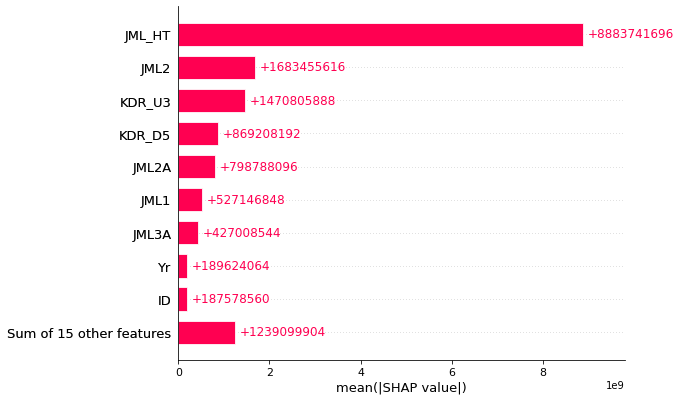

In [27]:
shap.plots.bar(shap_values)

In [28]:
## SHAP memiliki fitur visualisasi untuk tiap baris data yang kita miliki
# Berikut contoh besar kontribusi nilai dari tiap fitur pada data X_train baris ke-1
shap.plots.force(shap_values[0])

In [29]:
# Berikut contoh besar kontribusi nilai dari tiap fitur pada data X_train baris ke-30
shap.plots.force(shap_values[29])

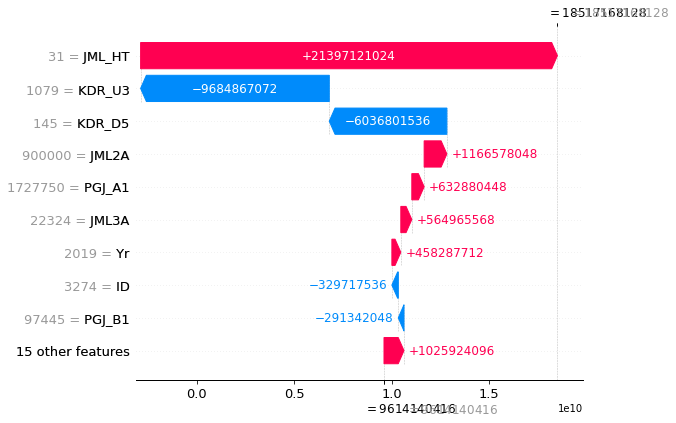

In [34]:
# Contoh visualisasi dari SHAP values terhadap data urutan ke-15
shap.plots.waterfall(shap_values[14])

In [264]:
## Proses penarikan hasil akhir

In [167]:
shap_values

.values =
array([[ 6.45988598e+10, -2.36081776e+08, -3.96994280e+07, ...,
         1.57174000e+06, -1.12943512e+08,  2.65495375e+05],
       [-1.91896576e+09,  2.47605120e+07,  2.59119648e+08, ...,
        -1.16401370e+07, -3.65311072e+08, -1.44634062e+05],
       [ 6.79740293e+10,  6.30461760e+07, -3.30595100e+07, ...,
         2.32313950e+06, -1.06296560e+08,  3.53097812e+05],
       ...,
       [-4.63292467e+09, -1.40209840e+08, -1.17759896e+08, ...,
         3.00762280e+07, -6.05898496e+08,  7.12972438e+05],
       [ 2.90900992e+10, -2.73288384e+08, -2.77912660e+07, ...,
        -2.11952525e+06, -8.17995520e+07,  2.94580875e+05],
       [-6.21238989e+09, -8.67613280e+07,  1.95562300e+07, ...,
        -7.38003600e+06,  1.75073152e+09, -1.42446450e+07]], dtype=float32)

.base_values =
array([9.61414e+09, 9.61414e+09, 9.61414e+09, 9.61414e+09, 9.61414e+09,
       9.61414e+09, 9.61414e+09, 9.61414e+09, 9.61414e+09, 9.61414e+09,
       9.61414e+09, 9.61414e+09, 9.61414e+09, 9.61414e+09,

In [168]:
shap_val_PDB2 = pd.DataFrame(shap_values.values)

In [169]:
shap_dat_PDB2 = pd.DataFrame(shap_values.data)

In [170]:
shap_base_PDB2 = pd.DataFrame(shap_values.base_values)

In [171]:
len(shap_val_PDB2[0]), len(shap_dat_PDB2[0]), len(shap_base_PDB2[0])

(148, 148, 148)

In [ ]:
## Proses ini dilakukan untuk mendapatkan informasi SHAP values dari masing-masing Kabupaten/Kota
# dari posisi tahun paling akhir dari kumpulan X_train

In [172]:
d = X_train[['ID','Yr']]

In [173]:
shap_val_PDB2[['IDs','Yrs']] = d.values

In [174]:
d1 = shap_val_PDB2.loc[shap_val_PDB2.groupby('IDs')['Yrs'].idxmax()]

In [175]:
d1.reset_index(inplace=True)

In [176]:
shap_dat_PDB2[['IDs','Yrs']] = d.values

In [177]:
d2 = shap_dat_PDB2.loc[shap_dat_PDB2.groupby('IDs')['Yrs'].idxmax()]

In [178]:
d2.reset_index(inplace=True)

In [179]:
shap_base_PDB2[['IDs','Yrs']] = d.values

In [180]:
d3 = shap_base_PDB2.loc[shap_base_PDB2.groupby('IDs')['Yrs'].idxmax()]

In [181]:
d3.reset_index(inplace=True)

In [ ]:
## Export data frame ke file Directory

In [182]:
# Mean_Score_Decrease dari model keseluruhan

xgb_msc.to_csv(r'E:\@CODES\@SAINS_DATA\Tableau\xgb_msc.csv')
rf_msc.to_csv(r'E:\@CODES\@SAINS_DATA\Tableau\rf_msc.csv')

In [183]:
# SHAP values dari masing-masing Kabupaten/Kota 

d1.to_csv(r'E:\@CODES\@SAINS_DATA\Tableau\shap_val_PDB2.csv')
d2.to_csv(r'E:\@CODES\@SAINS_DATA\Tableau\shap_dat_PDB2.csv')
d3.to_csv(r'E:\@CODES\@SAINS_DATA\Tableau\shap_base_PDB2.csv')